# Parseurs

Dans ce notebook nous utiliserons le parseur [lxml](http://lxml.de/) qui est un binding de libxml2 et [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/) 

## Parser de l'html

Beautiful Soup nous permet de parser simplement du contenu html. Même si le contenu est mal formé, le module bs reconstitue un arbre et offre des fonctions faciles à utiliser pour parcourir l'arbre ou y rechercher des éléments.  
Beautiful Soup n'est pas un parseur, il utilise les parseurs et offre une API simplifiée à ses utilisateurs.

Nous travaillerons directement avec du contenu en ligne. Fini les exercices bidons, cette fois nous allons nous confronter à une question essentielle : combien d'accordages *open tuning* Neil Young utilise et comment sont-ils répartis dans son oeuvre ?  
On trouve les infos sur les chansons de Neil Young et les accordages sur le fabuleux site [songx.se](http://songx.se/index.php)

Avec le module `urllib` nous allons pouvoir instancier un objet Beautiful Soup sans trop d'efforts

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

url = "http://songx.se/index.php"
html = urlopen(url)
soup = BeautifulSoup(html.read(), 'lxml')

Voilà nous avons maintenant un objet `soup` de classe Beautiful Soup.  
La [doc](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) est très claire.

In [3]:
# je cherche l'élement avec le tag 'title'
print(soup.title)
# le tag de l'élément
print(soup.title.name)
# le contenu textuel de l'élément
print(soup.title.string)

<title>SongX.se - The Neil Young Songbook</title>
title
SongX.se - The Neil Young Songbook


Les informations qui nous intéressent sont contenues dans des éléments comme celui-ci :  
    `<div class="songrow"><a href="?song=505">Clementine</a> <small>(cover)</small><div style="float:right;">EADGBE</div></div>`  
Où on trouve 1. le nom de la chanson ('Clementine') et l'accord utilisé ('EADGBE')  
Pour trouver ces éléments dans l'arbre nous allons utiliser la méthode `find_all`. La méthode renvoie un iterable.

In [4]:
for item in soup.find_all('div', attrs={'class':'songrow'})[:10]:
    print(item.a.string, item.div.string)
# on peut aussi utiliser la notation suivante
#for item in soup.find_all('div', class_="songrow"):

1956 Bubblegum Disaster EADGBE
A Dream That Can Last EADGBE
A Man Needs A Maid EADGBE
A Man Needs A Maid/Heart Of Gold (Suite) EADGBE
A New Day For Love EADGBE
A Rock Star Bucks A Coffee Shop EADGBE
Act Of Love EADGBE
After Berlin DADGBD
After The Garden EADGBE
After The Gold Rush EADGBE


In [5]:
# notre structure de données résultat
# un dictionnaire avec en clé l'accordage et en valeur la liste des chansons qui utilisent cet accordage
tunings = dict()
for item in soup.find_all('div', attrs={'class':'songrow'}):
    song_title = item.a.string
    tuning = item.div.string
    if tuning in tunings:
        tunings[tuning].append(song_title)
    else:
        tunings[tuning] = [song_title]

'Harvest Moon' utilise l'accordage DADGBE, y en a-t'il d'autres ?

In [6]:
tunings['DADGBE']

['Albuquerque',
 'Angry World',
 'Captain Kennedy',
 "Daddy Went Walkin'",
 'Dirty Old Man',
 'Give Me Strength',
 'Harvest Moon',
 'He Was The King',
 'Homegrown',
 'Like An Inca',
 'Live To Ride',
 'New Mama',
 'Night Song',
 'Ohio',
 'Prime Of Life',
 'Silver & Gold',
 'Sleeps With Angels',
 'Star Of Betlehem',
 'The Ways Of Love',
 "Tonight's The Night",
 'World On A String',
 'You And Me']

Combien de chansons pour chaque accordage ?

In [7]:
for tuning in sorted(tunings.keys(), key=lambda x: len(tunings[x]), reverse=True):
    print("{}: {}".format(tuning, len(tunings[tuning])))

EADGBE: 464
DADGBD: 30
DGCFAD: 23
DADGBE: 22
CGCFAC: 2
CGCFAD: 2
EbAbDbGbBb: 1
DGCFAA: 1
BbFBbEbGBb: 1


Allez hop un histogramme

<IPython.core.display.Javascript object>


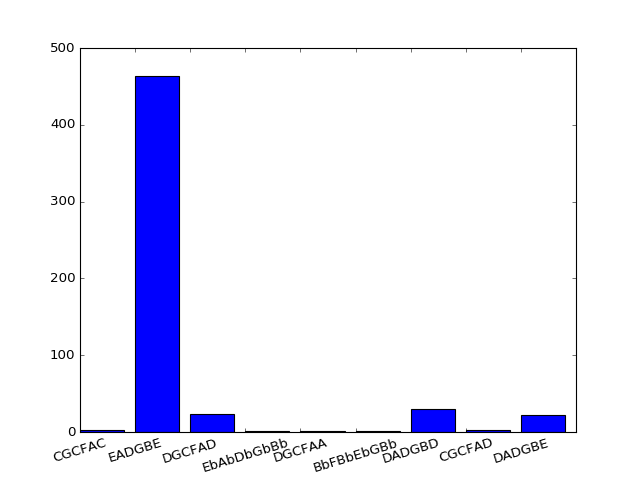

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
values = [len(tunings[x]) for x in tunings]
values
plt.bar(range(0, len(values)), values)
plt.xticks(range(0, len(values)), tunings.keys(), rotation=17)

plt.show()

## Parser de l'xml

Nous allons travailler sur un fichier au format TEI extrait du corpus *Corpus 14*  
PRAXILING - UMR 5267 (PRAXILING) (2014). Corpus 14 [Corpus]. ORTOLANG (Open Resources and TOols for LANGuage) - www.ortolang.fr, https://hdl.handle.net/11403/corpus14/v1.  

Le fichier se nomme ``josephine-1-150119.xml``. Il s'agit d'une lettre d'une femme de soldat à son époux.  
Nous allons extraire du fichier TEI les informations suivantes :  
- titre (``/TEI/teiHeader/fileDesc/titleStmt/title``)
- source (``/TEI/teiHeader/fileDesc/sourceDesc/p``)
- contenu de la lettre (``/TEI/text/body``)

### Avec lxml

Pourquoi `lxml` et pas `xml.etree.ElementTree` ? Parce que : [1](http://lxml.de/intro.html) et surtout [2](http://lxml.de/performance.html)  
La bonne nouvelle c'est que votre code sera aussi compatible avec `xml.etree.ElementTree` ou `xml.etree.cElementTree` parce que xml utilise l'API ElementTree. Sauf pour la méthode `xpath` qui est propre à `libxml`.

In [9]:
from lxml import etree
tree = etree.parse('josephine-1-150119.xml')
root = tree.getroot()

# Parcours des enfants de la racine (commentaires et éléments)
for child in root:
    print(child.tag)

<cyfunction Comment at 0x7fba18065830>
{http://www.tei-c.org/ns/1.0}teiHeader
<cyfunction Comment at 0x7fba18065830>
{http://www.tei-c.org/ns/1.0}facsimile
{http://www.tei-c.org/ns/1.0}text


Le fichier utilise l'espace de nom TEI : ``<TEI xmlns="http://www.tei-c.org/ns/1.0">``, nous devrons l'indiquer dans nos instructions de recherche.  
Voyons ça pour le titre (``/TEI/teiHeader/fileDesc/titleStmt/title``)

In [10]:
# la méthode find renvoie le premier élément qui correspond au chemin argument (ElementPath et non Xpath)
title = root.find("./tei:teiHeader/tei:fileDesc/tei:titleStmt/tei:title", namespaces={'tei':"http://www.tei-c.org/ns/1.0"})
print("Tag : {}".format(title.tag))
print("Texte : {}".format(title.text))

Tag : {http://www.tei-c.org/ns/1.0}title
Texte : Joséphine Pouchet à son époux le 19-01-1915 depuis Baillargues


Même traitement pour la source :

In [80]:
source = root.find("./tei:teiHeader/tei:fileDesc/tei:sourceDesc/tei:p", namespaces={'tei':"http://www.tei-c.org/ns/1.0"})
print("Tag : {}".format(source.tag))
print("Texte : {}".format(source.text))

Tag : {http://www.tei-c.org/ns/1.0}p
Texte : Correspondance de Joséphine Pouchet, numérisée par les Archives Départementales de l'Hérault.


lxml a aussi une méthode ``xpath`` qui permet d'utiliser directement des expressions xpath (sans oublier les espace de noms pour notre fichier) :

In [11]:
source = root.xpath("/tei:TEI/tei:teiHeader/tei:fileDesc/tei:sourceDesc/tei:p", namespaces={'tei':'http://www.tei-c.org/ns/1.0'})
print(type(source)) #xpath retourne une liste
print(source[0].text)
#ou bien
source = root.xpath("/tei:TEI/tei:teiHeader/tei:fileDesc/tei:sourceDesc/tei:p/text()", namespaces={'tei':'http://www.tei-c.org/ns/1.0'})
print(source[0])

<class 'list'>
Correspondance de Joséphine Pouchet, numérisée par les Archives Départementales de l'Hérault.
Correspondance de Joséphine Pouchet, numérisée par les Archives Départementales de l'Hérault.


Pour le contenu il faut ruser. La difficulté ici tient à l'utilisation d'élements `<lb/>` de type 'milestones' pour noter les retours à la ligne :  
```xml
<p>
je reponse a ton aimableux lettres<lb/>
que nous a fait plaisir en naprenas<lb/>
que tu et enbonne santes car il<lb/>
anais de maime pour nous<lb/>
</p>
```

In [116]:
# la méthode findall renvoie une liste avec tous les éléments correspondant au chemin argument
body = root.findall("./tei:text/tei:body/tei:p", namespaces={'tei':"http://www.tei-c.org/ns/1.0"})
for elem in body:
    print(elem.text)


cher Laurent

je reponse a ton aimableux lettres

cher Laurent je repons a la cartes


Ici on ne récupère que les noeuds text précédant les éléments `<lb/>`  
Une requête `xpath` va nous permettre de récupérer tous les noeuds text

In [12]:
body = root.xpath("//tei:text/tei:body//text()", namespaces={'tei':"http://www.tei-c.org/ns/1.0"})
for text in body:
    print(text, end="")



Baillargues Le 19 janvier 1915


cher Laurent


je reponse a ton aimableux lettres
que nous a fait plaisir en naprenas
que tu et enbonne santes car il
anais de maime pour nous


cher Laurent je repons a la cartes
de ma mère quelles et venue au
jourdhui pour de faire partire
partir un paquet quil aillae
les chosette sausice chocolas une
paire de chosette pour Louis
je pense que vous magerè ensenbleus
tu feras repons a la maison te
suite que tu rese vras le paquet
je te dirais que ten le midi il
fait frois il fait du vent glasais
et toi au pas de calais tu nous
dit quil pleus mai tu nous parles
pas si tu a ases pour te garendir
du froit cil te maque quelles chose

tu nas que ledire quon de len verras
verras tu nous dit que charles ta
Ecrie et ta soeux et ta dit que
je lui et envoiez la photot
plurien a te dire pour le moment
que de ten voiez une grose
carriese de tous et boutounase
de ton petit enge 
adorè Albert encorre une foi
te plui Milles baisées te tous
ta fenme pour la vie
Josep

## avec DOM

L'API `ElementTree` est propre à Python, `DOM` est une API indépendante d'un langage de programmation. Il existe des implémentations `DOM` dans la plupart des langages de programmation modernes.  

In [14]:
from xml.dom import minidom
dom = minidom.parse("josephine-1-150119.xml")
# l'objet Document
dom

In [15]:
title = dom.getElementsByTagNameNS("http://www.tei-c.org/ns/1.0", 'title')[0] # un seul élément 'title' dans le document
print(title) # title est un objet Element, pour accèder au contenu textuel il faut récupérer le noeud texte
print(title.lastChild.nodeName)
print(title.lastChild.nodeValue)

<DOM Element: title at 0x7fb9f8162c28>
#text
Joséphine Pouchet à son époux le 19-01-1915 depuis Baillargues


idem pour la source, sauf qu'on ne peut pas se permettre de rechercher tous les éléments `p`.  
Il faut trouver l'élément `p` fils de `sourceDesc`

In [17]:
sourceDesc = dom.getElementsByTagNameNS("http://www.tei-c.org/ns/1.0", 'sourceDesc')[0]
for node in sourceDesc.childNodes:
    if node.localName == "p":
        print(node.lastChild.nodeValue)

Correspondance de Joséphine Pouchet, numérisée par les Archives Départementales de l'Hérault.


Et maintenant le contenu et ses éléments milestones.  
Pour garder la forme vous réécrirez les boucles `for` suivies de `if` en listes en intension.

In [34]:
body = dom.getElementsByTagNameNS("http://www.tei-c.org/ns/1.0", 'body')[0]
for node in body.childNodes:
    if node.localName == "p" or "opener":
        for in_node in node.childNodes:
            if in_node.nodeName == "#text":
                print(in_node.nodeValue, end="")


Baillargues Le 19 janvier 1915

cher Laurent

je reponse a ton aimableux lettres
que nous a fait plaisir en naprenas
que tu et enbonne santes car il
anais de maime pour nous

cher Laurent je repons a la cartes
de ma mère quelles et venue au
jourdhui pour de faire 
partir un paquet quil 
les chosette sausice chocolas une
paire de chosette pour Louis
je pense que vous magerè ensenbleus
tu feras repons a la maison te
suite que tu rese vras le paquet
je te dirais que ten le midi il
fait frois il fait du vent glasais
et toi au pas de calais tu nous
dit quil pleus mai tu nous parles
pas si tu a ases pour te garendir
du froit cil te maque quelles chose

tu nas que ledire quon de len 
verras tu nous dit que charles ta
Ecrie et ta soeux et ta dit que
je lui et envoiez la photot
plurien a te dire pour le moment
que de ten voiez une grose
carriese de tous et boutounase
de ton petit enge 
adorè Albert encorre une foi
te plui Milles baisées te tous
ta fenme pour la vie
Josephine Pouchet
bien le bo